In [1]:
#Librería de graficación
import matplotlib.pyplot as plt
import matplotlib as mp
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature


#Librerías de procesamiento matemático y lectura de archivos
import numpy as np
import netCDF4 as nc
import pandas as pd
import glob
import os


#Librería de estadística
import scipy as sp

#librería para manejo de fechas
from datetime import datetime,timedelta


# from mpl_toolkits.axes_grid1 import make_axes_locatable

# plt.style.use("seaborn")
# mp.rcParams['font.size'] = 20

In [2]:
def reading_netcdf(ruta):
    data=nc.Dataset(ruta)
    for i in data.variables:
        try:
            print (i,data.variables[i].shape,data.variables[i].units) 
        except:
            print (i,data.variables[i].shape) 
    print("\n")
    data_variables=[np.array(data[i][:]) for i in list(data.variables.keys())]
    return data_variables

In [3]:
rutas = np.sort(glob.glob("../Dataset/CMEMS_ECMFW/*.nc"))

#Al estar por años se debe concatenar
for i in range(0,len(rutas)):
    if i==0:
        [adt,time,lat,lon,ugos,vgos,vgosa,sla,ugosa]=reading_netcdf(rutas[i])
    else:
        [adt,time2,lat,lon,ugos,vgos,vgosa,sla2,ugosa]=reading_netcdf(rutas[i])
        sla=np.concatenate((sla,sla2))
        time=np.concatenate((time,time2))


adt (366, 45, 185) m
time (366,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (366, 45, 185) m/s
vgos (366, 45, 185) m/s
vgosa (366, 45, 185) m/s
sla (366, 45, 185) m
ugosa (366, 45, 185) m/s


adt (366, 45, 185) m
time (366,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (366, 45, 185) m/s
vgos (366, 45, 185) m/s
vgosa (366, 45, 185) m/s
sla (366, 45, 185) m
ugosa (366, 45, 185) m/s


adt (366, 45, 185) m
time (366,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (366, 45, 185) m/s
vgos (366, 45, 185) m/s
vgosa (366, 45, 185) m/s
sla (366, 45, 185) m
ugosa (366, 45, 185) m/s


adt (367, 45, 185) m
time (367,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (367, 45, 185) m/s
vgos (367, 45, 185) m/s
vgosa (367, 45, 185) m/s
sla (367, 45, 185) m
ugosa (367, 45, 185) m/s


adt (366, 45, 185) m
tim

In [4]:
sla[sla<=-1000]=np.nan

In [5]:
serie=np.nanmean(sla,axis=1)
serie_temp=np.nanmean(serie,axis=1)

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [6]:
da=[datetime(1950,1,1,0,0,0)+timedelta(days=int(time[w])) for w in range (0,len(time))]
date=pd.DatetimeIndex(da)

In [7]:
serie_sla=pd.Series(serie_temp,date)

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


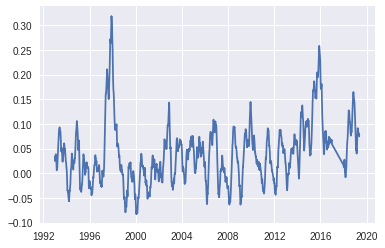

In [8]:
plt.plot(serie_sla)

In [9]:
serie_rolling=serie_sla.rolling(366).mean()
serie_rolling=serie_rolling[365:]

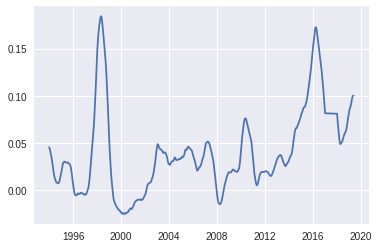

In [10]:
plt.plot(serie_rolling)

In [11]:
freq_sla=np.fft.fftfreq(len(serie_rolling))
fft_sla=np.fft.fft(serie_rolling.values)
potencia=np.abs((1/len(serie_rolling))*fft_sla)**2 #Notar que tiene el factor de escalamiento 1/n
periodo=1/freq_sla
freq_pos=np.where(freq_sla>=0)[0]

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


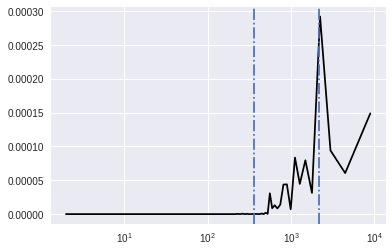

In [12]:
plt.plot(periodo[freq_pos],potencia[freq_pos],'k')
plt.xscale('log')
plt.axvline(365,ls='-.')
plt.axvline(365*6,ls='-.')

Estadísticamente significativo no necesariamentes es físicamente significativo

- para algo físicamente significativo se puede notar el porcentaje de varianza
- para algo estadísticamente significativo se debe mirar la longitud los datos y qué tan casual es que ese espectro se haya obtenido con datos aleatorios (random) y con parámetros estadísticos similares.


* Ruido blanco: ruido no correlacionado (radio sin frecuencia emitida)
* Ruido rojo: ruido correlacionado

In [13]:
serie_copy=np.copy(serie_rolling.values)

In [14]:
n=1000
matriz=np.zeros((n,len(serie_copy)))*np.nan
for i in range(n):
    np.random.shuffle(serie_copy)
    fft_sla2=np.fft.fft(serie_copy)
    potencia2=np.abs((1/len(serie_copy))*fft_sla2)**2 #Notar que tiene el factor de escalamiento 1/n
    matriz[i,:]=potencia2

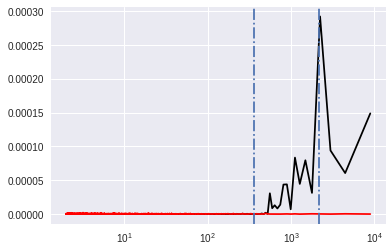

In [23]:
plt.plot(periodo[freq_pos],potencia[freq_pos],'k')
plt.plot(periodo[freq_pos],matriz[800,:][freq_pos],'r')
plt.xscale('log')
plt.axvline(365,ls='-.')
plt.axvline(365*6,ls='-.')

In [24]:
perc_99=np.array([np.percentile(matriz[:,i],99) for i in range (0,len(freq_sla))])

In [26]:
perc_99

array([1.45923446e-03, 9.91657230e-07, 1.02740901e-06, ...,
       9.97269406e-07, 1.02740901e-06, 9.91657230e-07])

<IPython.core.display.Javascript object>


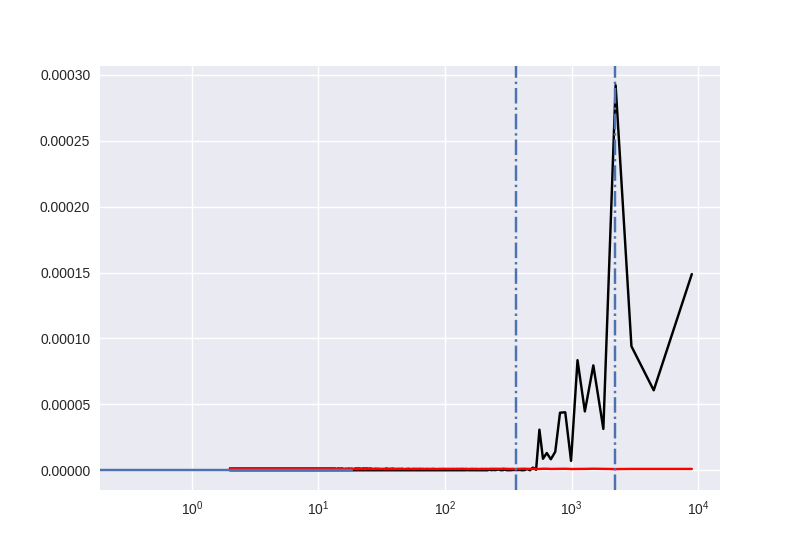

In [28]:
plt.plot(periodo[freq_pos],potencia[freq_pos],'k')
plt.plot(periodo[freq_pos],perc_99[freq_pos],'r')
plt.xscale('log')

plt.axvline(365,ls='-.')
plt.axvline(365*6,ls='-.')

# Fourier por ventanas

Una serie es estacionaria cuando alguna propiedad (momento estadístico o contenido frecuencil) cambia con el tiempo y por lo tanto tiene problemas con Fourier.

Ejemplo: Serie de 3 frecuencias distintas

In [2]:
t=np.arange(0,6*np.pi,0.01*np.pi)

In [3]:
w1=10
s1=np.sin(w1*t)

w2=5
s2=np.sin(w2*t)

w3=1
s3=np.sin(w3*t)

s_f=np.concatenate((s1,s2,s3))

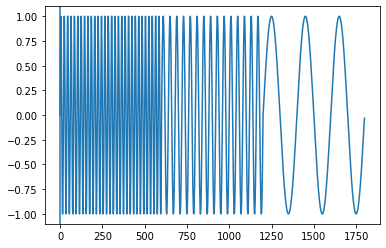

In [4]:
plt.figure()
plt.plot(s_f)
plt.axvline()
# plt.plot(t,s2)
# plt.plot(t,s3)

\begin{equation}
    f(\omega,a)=\int f(t)e^{-2\pi i \omega t}g_{T}(a)dt
\end{equation}

$g_{T}$ es la ventana

Pueden existir problemas en los bordes, por lo que debe tenerse en cuenta una ventana cuadrada o gaussiana. Cuando es gaussiana se coloca la desviación estándar y permite que caiga más suave.

-**Investigar la susceptibilidad del proceso a un T**

-**Cuando ocurren los picos**

- Al ser la transformada de Fourier un análisis de resolución única, existe el problema que para unas frecuencias se capte bien la información y para otras no. 

## Elegir T

In [39]:
T=300

## Fourier por ventanas

In [50]:
potencias=np.zeros((len(s_f),len(s_f)-T))*1j
ffTs=np.zeros((len(s_f),len(s_f)-T))*1j

for i in range(0,len(s_f)-T):
    window=np.zeros((len(s_f),))
    window[i:i+T+1]=1 
    serie=s_f*window
    freq=np.fft.fftfreq(len(serie))
    ffTs[:,i]=np.fft.fft(serie)
    potencias[:,i]=np.abs((1/len(serie))*ffts[:,i])**2 #NoTar que Tiene el facTor de escalamienTo 1/n

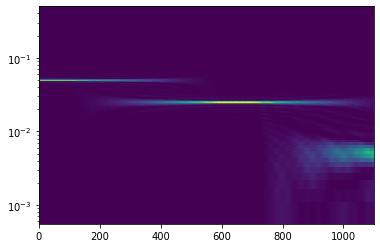

In [51]:
plt.figure()
x=np.arange(0,len(s_f)-T,1)
freq_pos=np.where(freq>0)[0]

plt.pcolormesh(x,freq[freq_pos],potencias[freq_pos,:].real)
plt.yscale('log')

Muchas veces se puede obtener una buena posición temporal pero no una buena posición frecuencial



In [ ]:
np.arange()

## EOF's

In [19]:
sla.shape

(9289, 45, 185)

In [20]:
sla_r = np.reshape(sla,[sla.shape[0],sla.shape[1]*sla.shape[2]])

In [21]:
%%time
U_sla,S_sla,Vh_sla = np.linalg.svd(sla_r, full_matrices=True)

KeyboardInterrupt: 

In [ ]:
print(U_air.shape, S_air.shape,Vh_air.shape)